# ML Approach (Sklearn + Pandas + Sweetviz + LazyPredict + Feature Engineering + Feature Selection + Model Selection + Model Ensembling)

In this notebook, I use `sklearn` as my machine learning framework; `sweetviz` for the exploratory data analysis (EDA); `pandas` for **data cleaning, data correcting, data engineering, data labeling**; `lazypredict` for the overview of machine learning model performance. I also use `sklearn` to implement **feature selection, model selection, and voting ensemble**. 

We will go through the following process in this notebook: 

1. Loading data
2. Using `sweetviz` to check whether the data missing or imbalance 
3. Implementing data cleaning, correcting, completing, and creating (also known as `feature engineering`) 

By this stage, we will get the **features** and **labels** for machine learning training.

4. Using `lazypredict` to find the best models for this problem
5. Select a model that performs best to do the following implementation:
    1. In `feature selection`, we will eliminate the redundant or less useful features
    2. In `model selection`, we will use grid search to find the best hyperparameters
6. Prediction

By this stage, we will have chosen the best model and implement both feature and model selection by eliminating some features and find the most suitable hyperparameters of the model; We then use the trained model to predict the testset.

7. Using `lazypredict` to select multiple models that perform well and ensemble them using `VotingClassifier`
    1. We skip the `feature selection` but implement `model selection` before we ensemble the models
8. Prediction

> Ref: https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy/notebook

# Loading Data

In [9]:
from IPython.display import clear_output
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
warnings.filterwarnings('ignore')
clear_output()

In [10]:
from pathlib import Path
data_dir = Path("datasets")
submission_dir = Path("submissions")

In [8]:
list(data_dir.iterdir())

[WindowsPath('datasets/cheat.csv'),
 WindowsPath('datasets/test.csv'),
 WindowsPath('datasets/train.csv')]

In [21]:
train_data = pd.read_csv(data_dir / "train.csv")
test_data = pd.read_csv(data_dir / "test.csv")

In [22]:
train_data.iloc[:3]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


# EDA & Preparing Data

In [23]:
data_cleaner = [train_data, test_data]

First, we use library `sweetviz` to do a quick data exploration on the titanic dataset.

1. Values in `age` are missing 177 (20%) in `train_data` and 86 (21%) in `test_data`. 
2. Values in `cabin` are missing 687 (77%) and 327 (78%) in both datasets.
3. The features that have the most impact on `Survived` are `Sex` and `Fare`.


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)



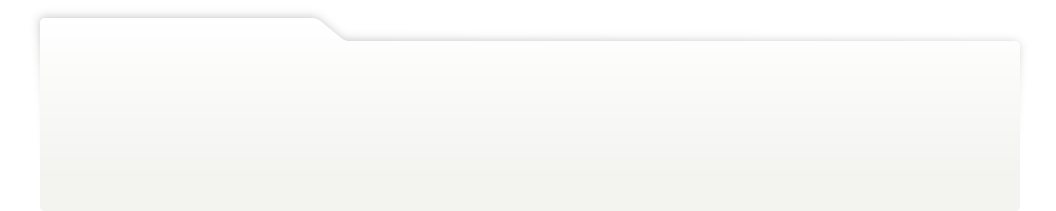
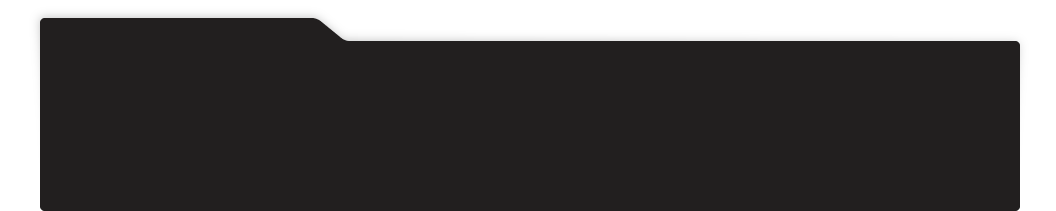
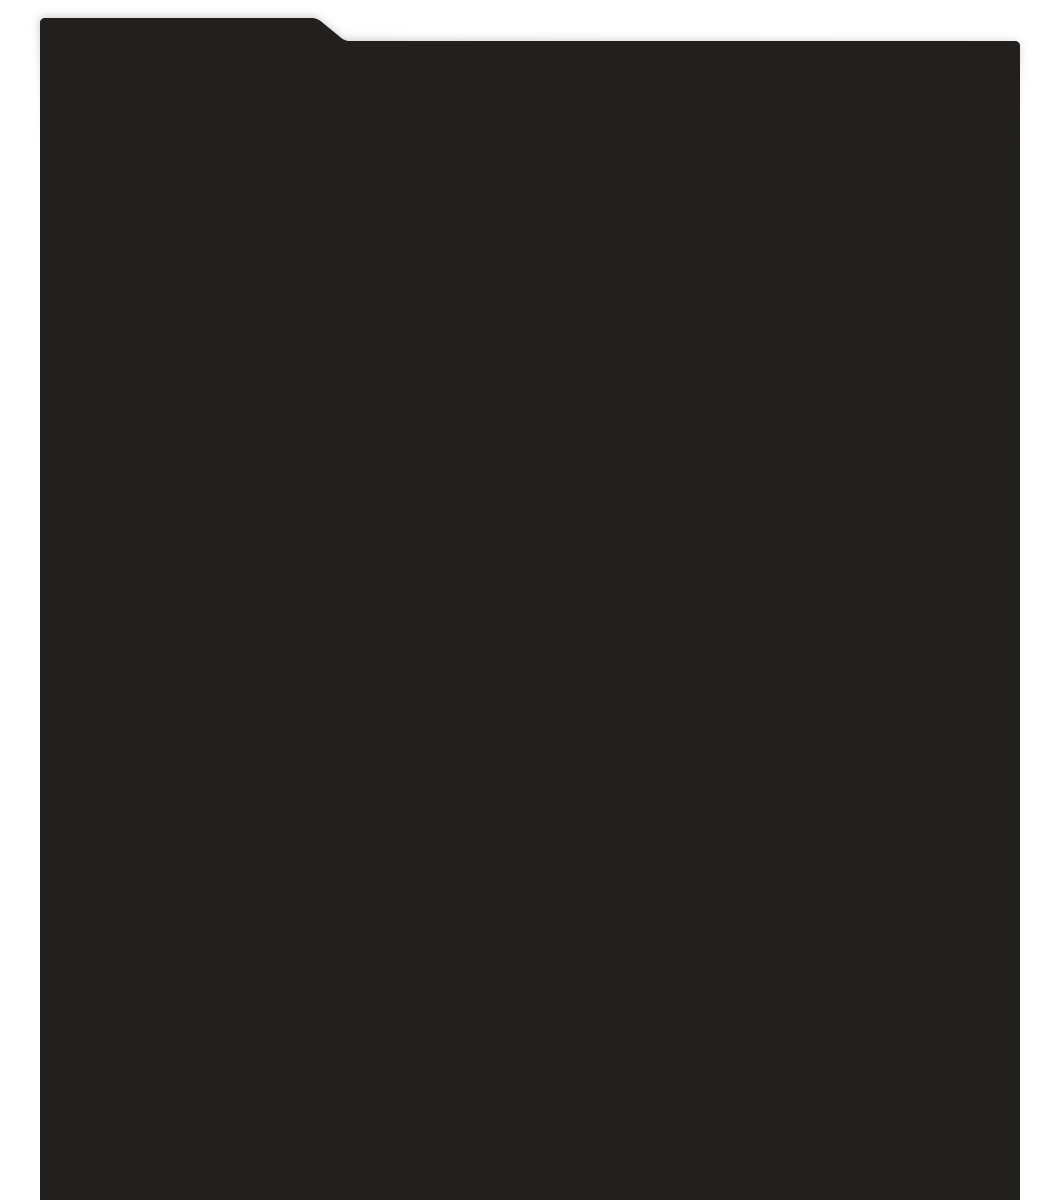
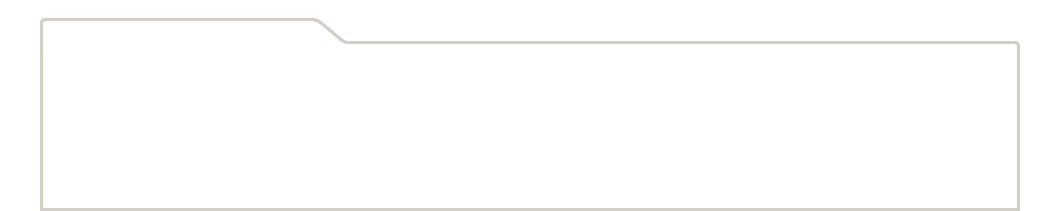
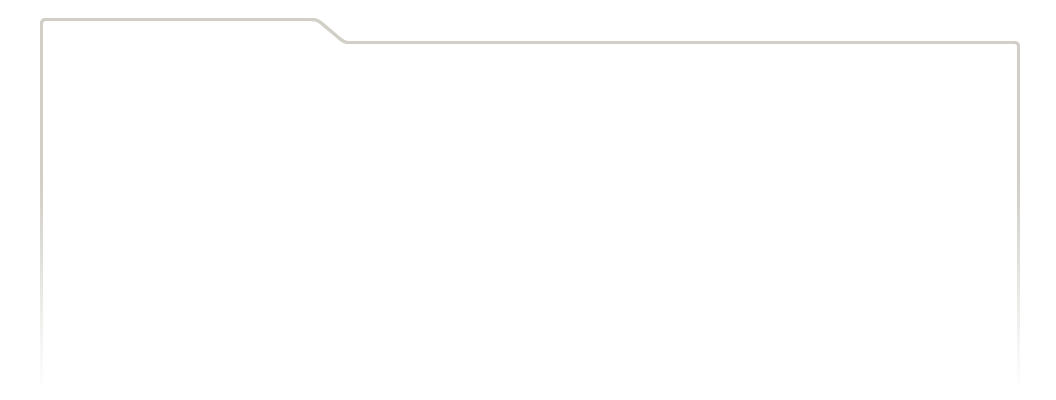
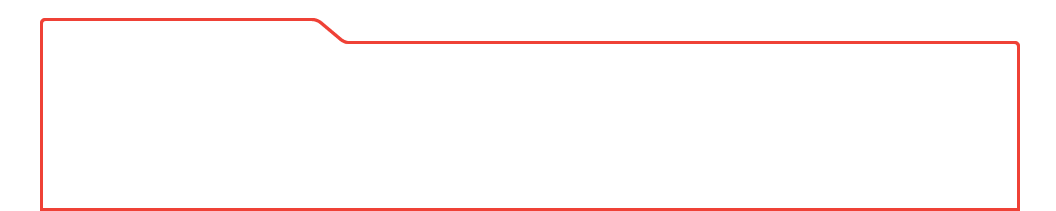
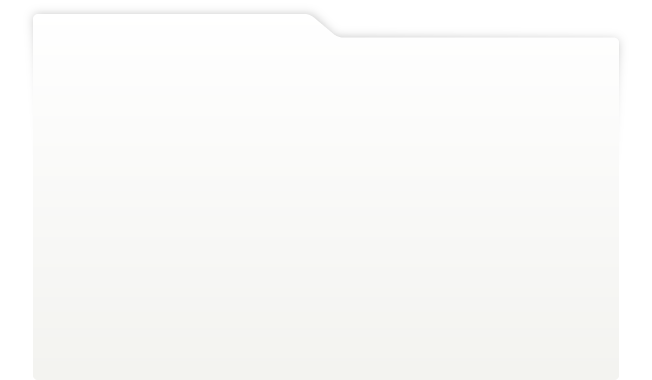
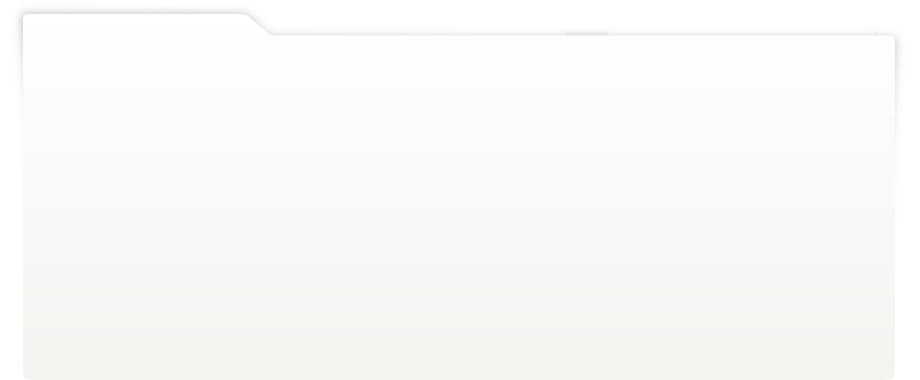
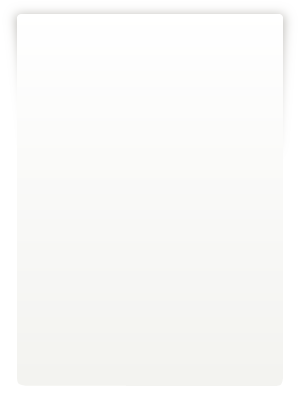
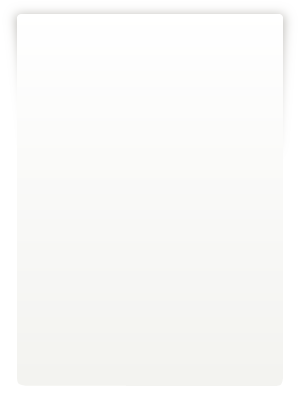
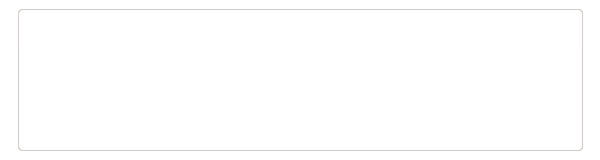
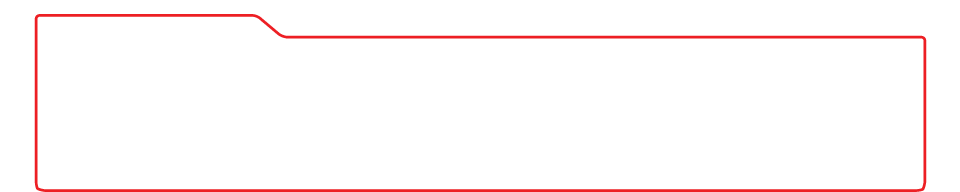
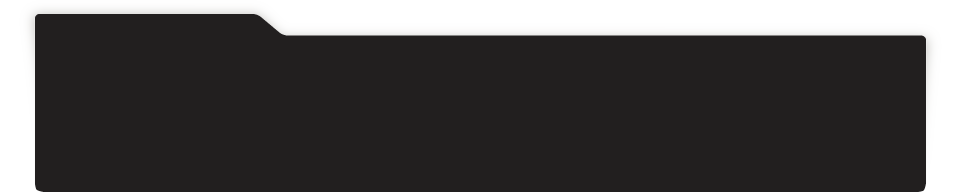
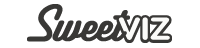
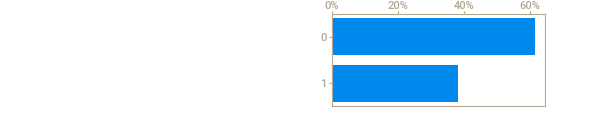
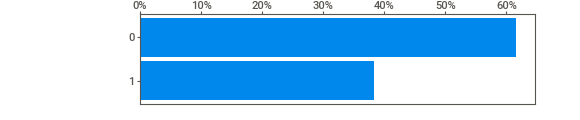
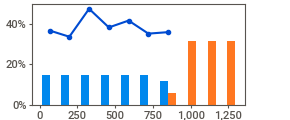
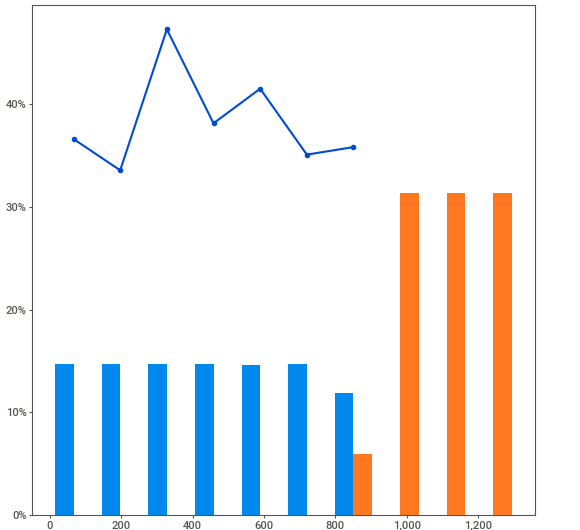
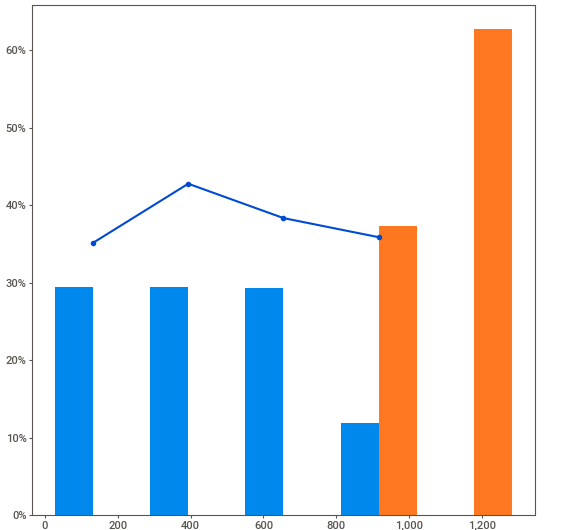
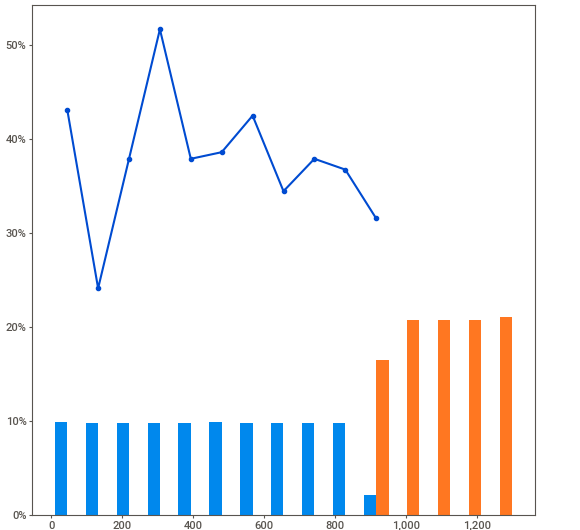
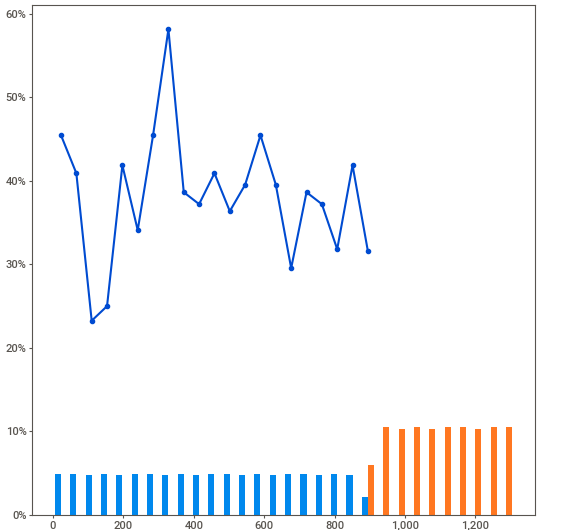
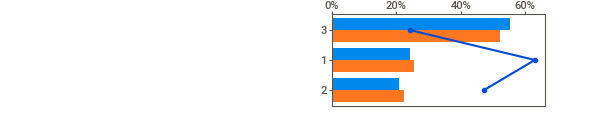
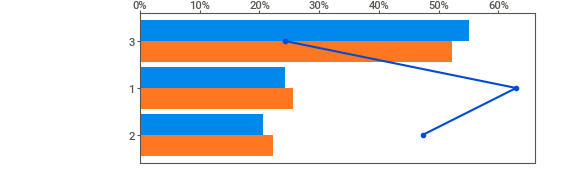
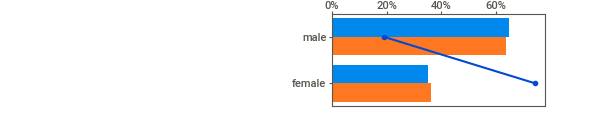
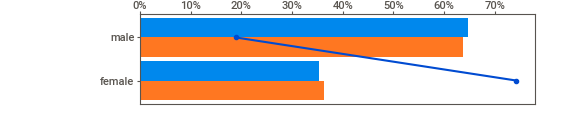
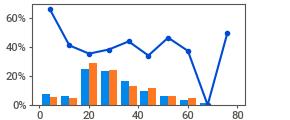
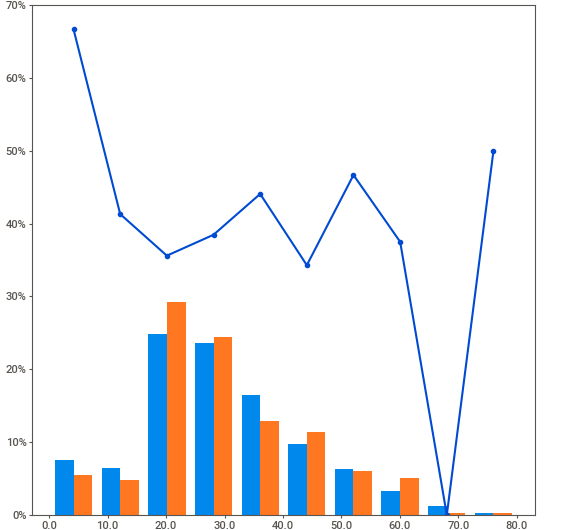
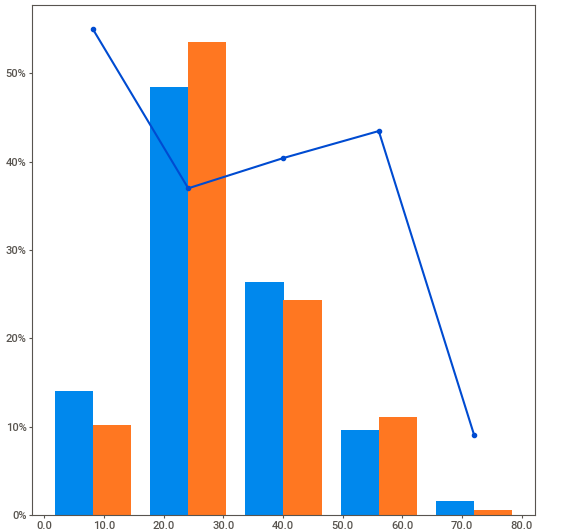
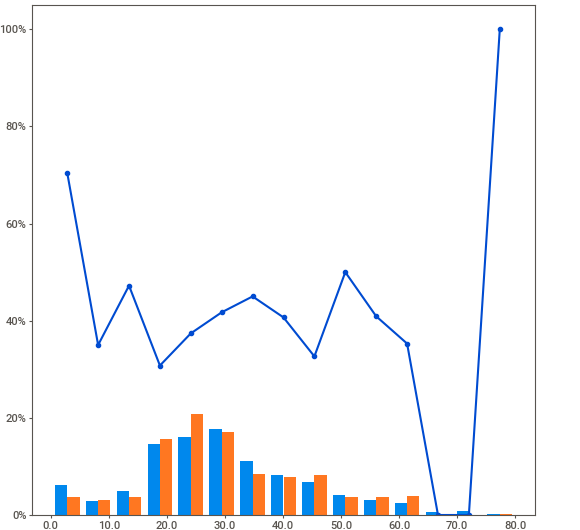
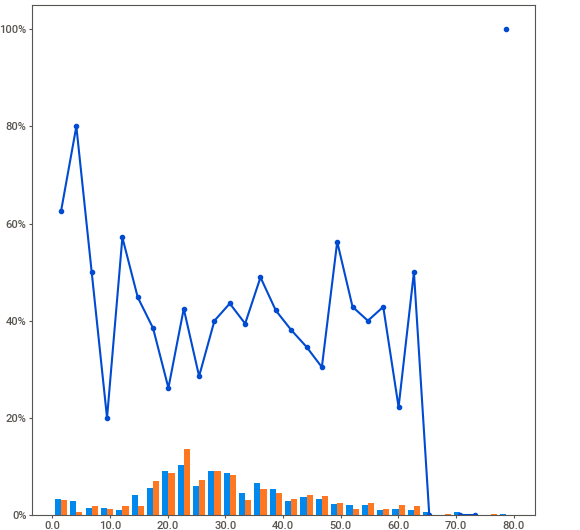
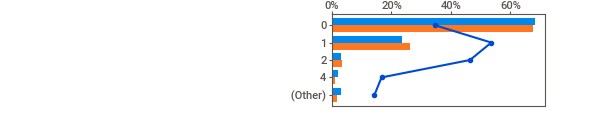
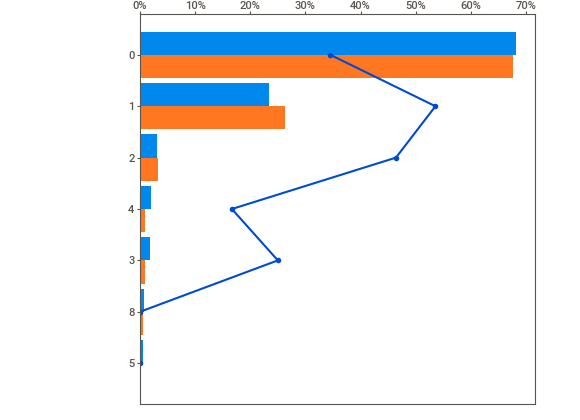
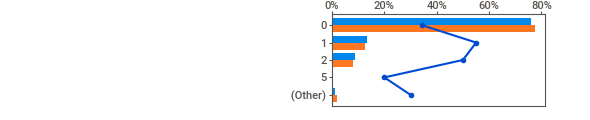
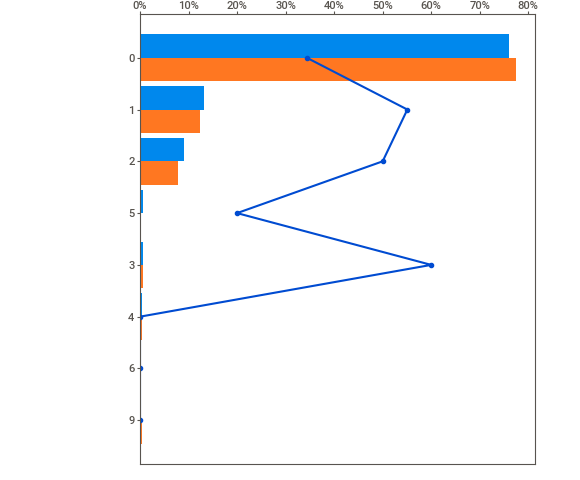
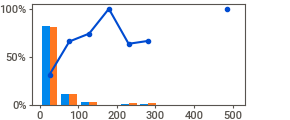
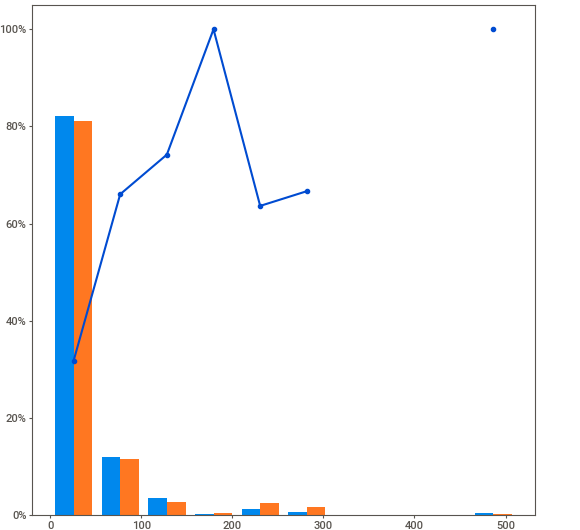
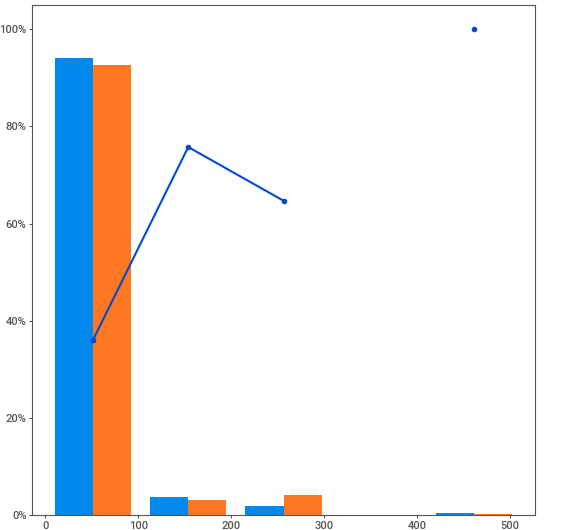
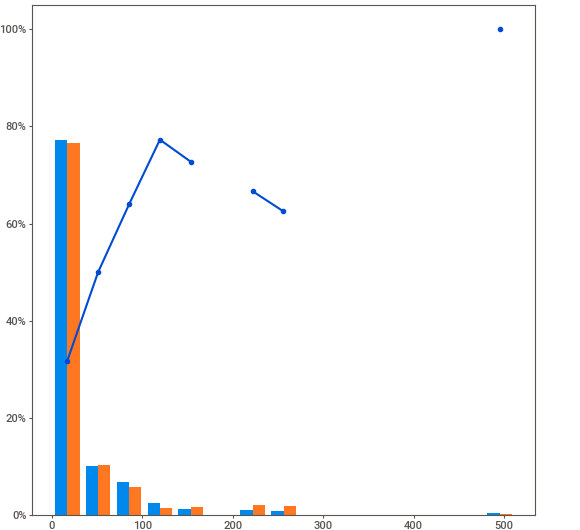
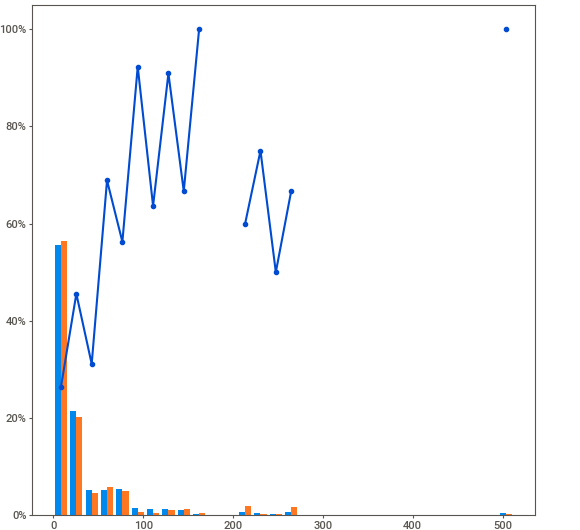
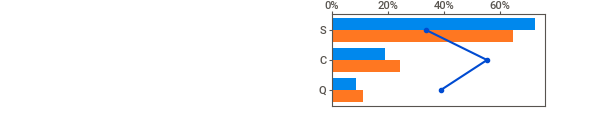
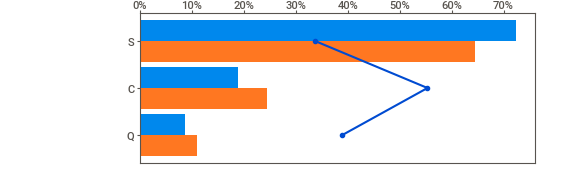
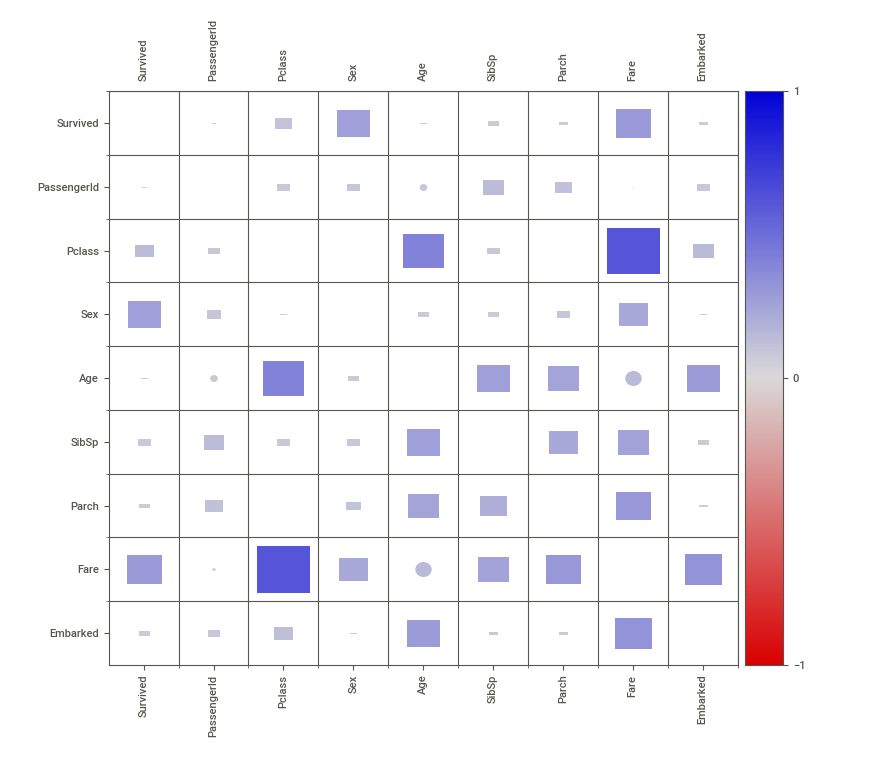
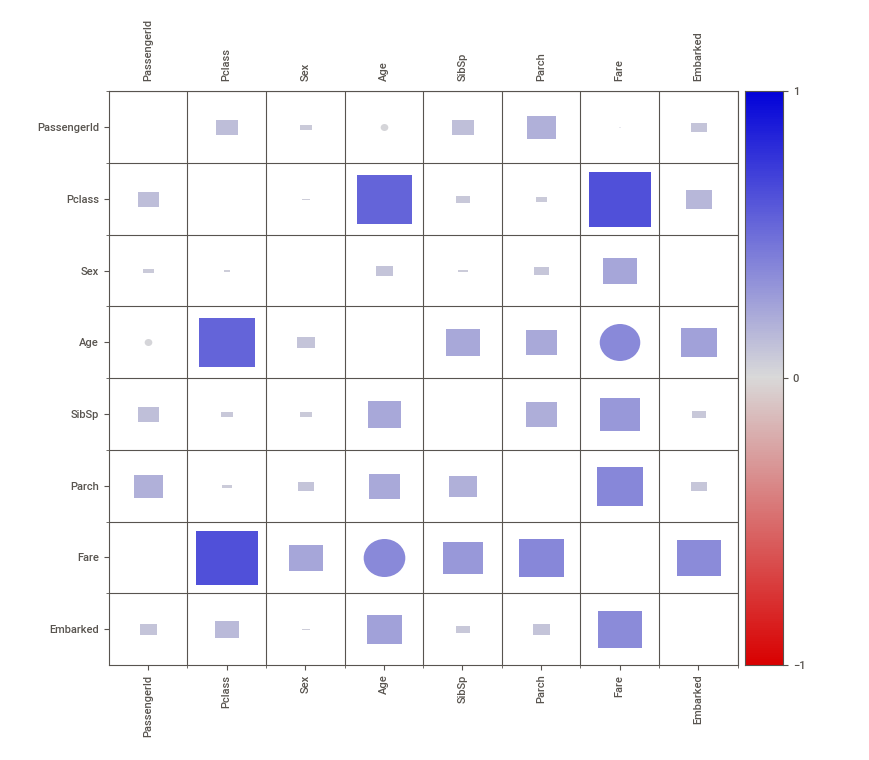

In [18]:
import sweetviz as sv
report = sv.compare([train_data, "Train"], [test_data, "Test"], target_feat="Survived", pairwise_analysis="on")
report.show_notebook()

## Data Correcting and Completing

We fill the missing values of `age`, `embarked`, `fare` in both `train_data` and `test_data` with median and mode respectively.

Then we drop the `id`, `cabin`, `ticket` columns from `train_data` because:

1. `PassengerId` has no meaning.
2. `Cabin` has too many missing values.
3. `Ticket` has no meaning from its distribution.

In [24]:
test_ids = test_data["PassengerId"]

for dataset in data_cleaner:
    dataset["Age"].fillna(dataset["Age"].median(), inplace=True)
    dataset["Embarked"].fillna(dataset["Embarked"].mode()[0], inplace=True)
    dataset["Fare"].fillna(dataset["Fare"].median(), inplace = True)

    drop_column = ['PassengerId', 'Cabin', 'Ticket']
    dataset.drop(drop_column, axis=1, inplace=True)

## Data Creating (Feature Engineering)

We extract the information from `SibSp` and `Parch`, then create two new features: `FamilySize` and `IsAlone`.

From the `Name` feature, we can get the `Title` of each person. After the extraction, we can drop the `Name` column.

Finally, we use `qcut()` and `cut()` from pandas, to convert the `Age` and `Fare` into discrete intervals, then we drop the `Age` and `Fare`.

> - [pandas的cut&qcut函數](https://medium.com/@morris_tai/pandas%E7%9A%84cut-qcut%E5%87%BD%E6%95%B8-93c244e34cfc)
> - [pandas的cut，qcut函数的使用和区别](https://zhuanlan.zhihu.com/p/68194655)


In [25]:
for dataset in data_cleaner:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 1  #initialize to 1 = is alone
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0  # now update to no if family size is greater than 1

    # Get "Mr", "Miss", "Mrs", and many titles from the name column.
    dataset['Title'] = dataset["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    title_counts = dataset['Title'].value_counts() < 10
    dataset["Title"] = dataset["Title"].apply(lambda x: "Misc" if title_counts.loc[x] == True else x)

    # Divide the `Fare` into 4 intervals with similar quantities.
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4, labels=False)

    # Divide the `Age` into 4 discrete intervals according to its value.
    dataset['AgeBin'] = pd.cut(dataset['Age'], [0, 25, 50, 75, 100], labels=False)

    dataset.drop(columns=["Name", "Age", "Fare"], inplace=True)

train_data.sample(5)

,Survived,Pclass,Sex,SibSp,Parch,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
222,0,3,male,0,0,S,1,1,Mr,1,2
61,1,1,female,0,0,S,1,1,Miss,3,1
96,0,1,male,0,0,C,1,1,Mr,3,2
255,1,3,female,0,2,C,3,0,Mrs,2,1
840,0,3,male,0,0,S,1,1,Mr,1,0


## Data Converting

In this step, we have to convert the features: `Sex`, `Title` into **discrete form** by calling `pandas.get_dummies()`.

In [26]:
train_data = pd.get_dummies(train_data)
train_data.sample(5)

,Survived,Pclass,SibSp,Parch,FamilySize,IsAlone,FareBin,AgeBin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
247,1,2,0,2,3,0,2,0,1,0,0,0,1,0,0,0,0,1
251,0,3,1,1,3,0,1,1,1,0,0,0,1,0,0,0,0,1
119,0,3,4,2,7,0,3,0,1,0,0,0,1,0,0,1,0,0
84,1,2,0,0,1,1,1,0,1,0,0,0,1,0,0,1,0,0
837,0,3,0,0,1,1,1,1,0,1,0,0,1,0,0,0,1,0


In [27]:
test_data = pd.get_dummies(test_data)
test_data.sample(5)

,Pclass,SibSp,Parch,FamilySize,IsAlone,FareBin,AgeBin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
82,1,0,0,1,1,2,1,0,1,0,0,1,0,0,0,1,0
84,2,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1,0
199,3,0,0,1,1,1,1,1,0,0,0,1,0,0,0,0,1
231,1,0,0,1,1,2,0,1,0,0,0,1,0,0,1,0,0
120,2,0,0,1,1,2,0,1,0,0,0,1,0,0,1,0,0


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)



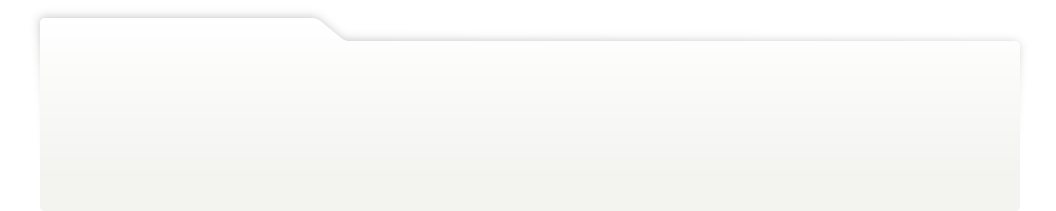
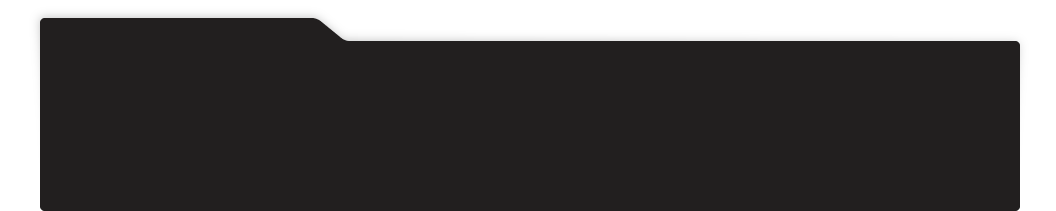
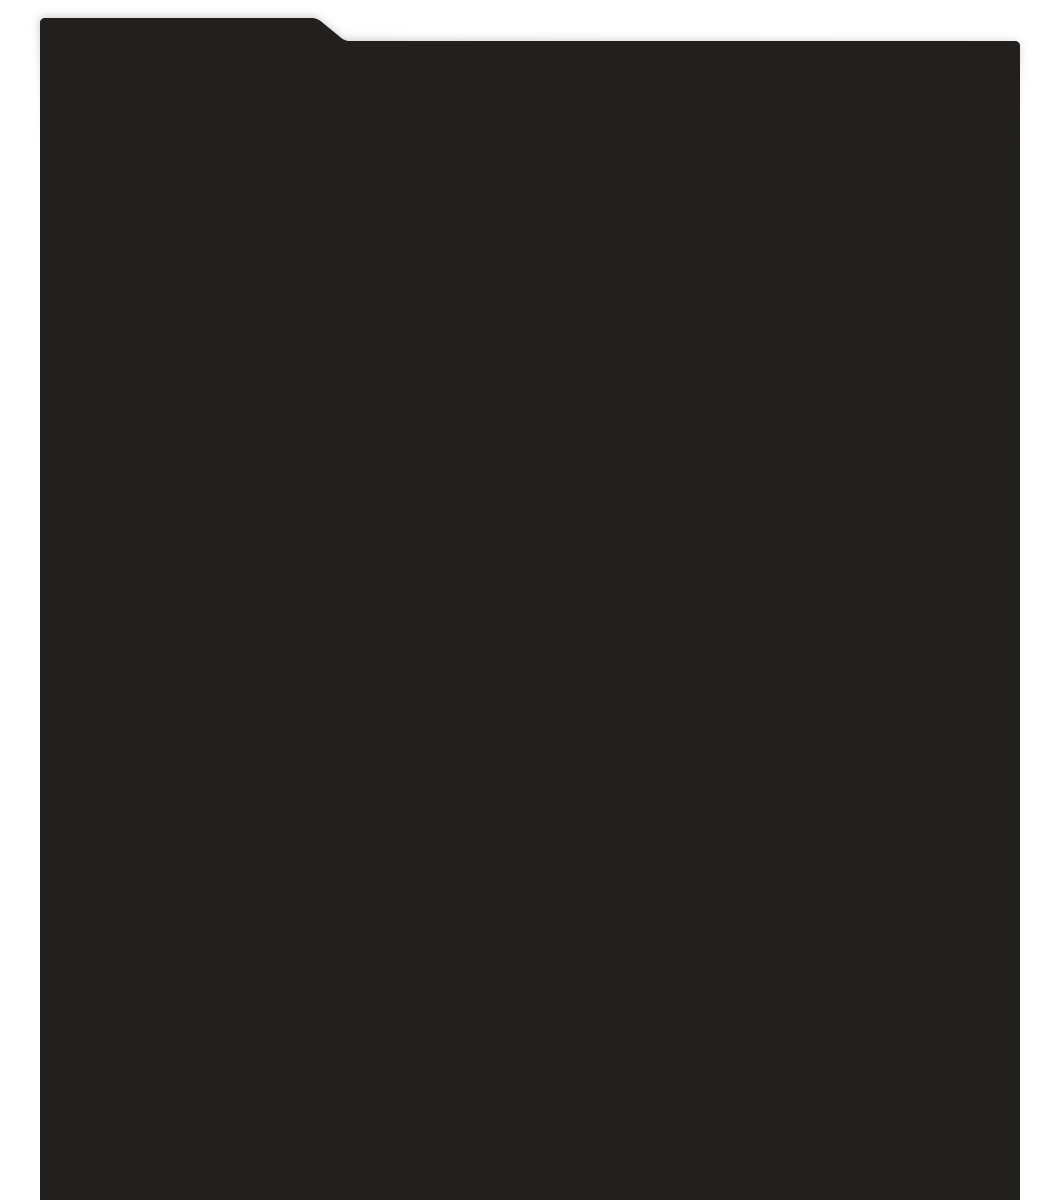
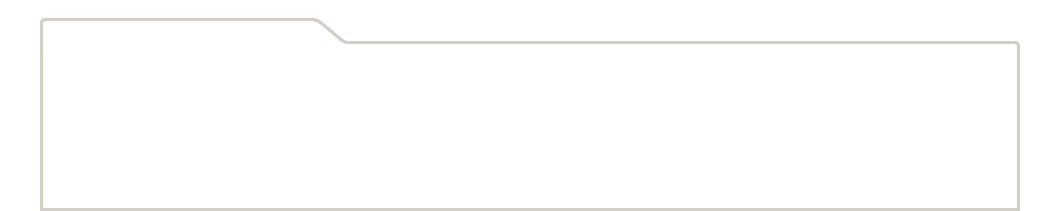
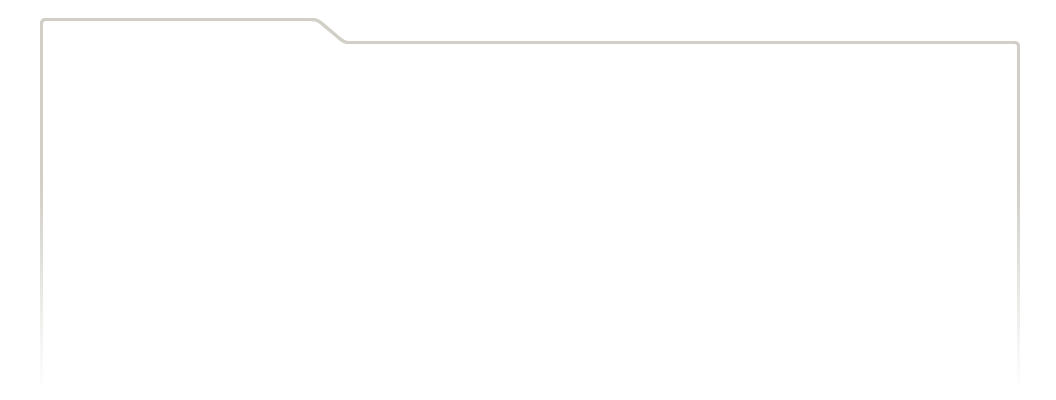
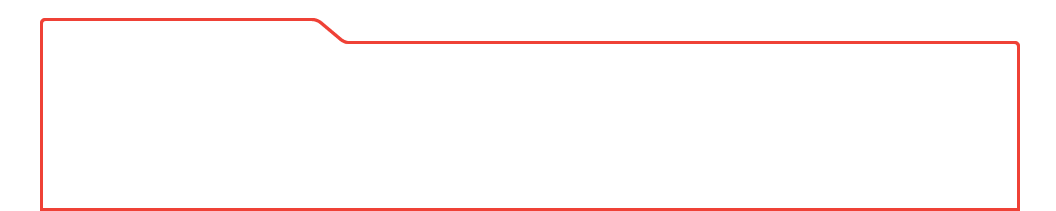
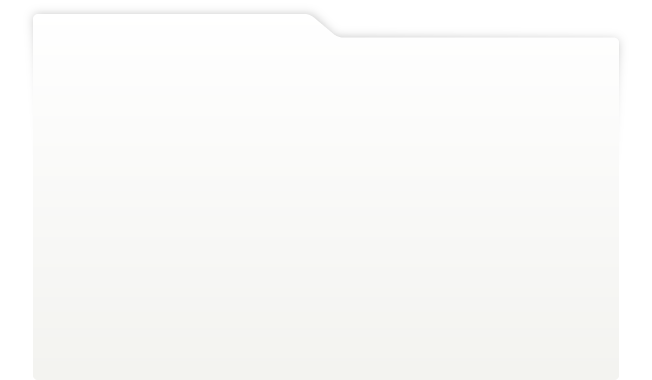
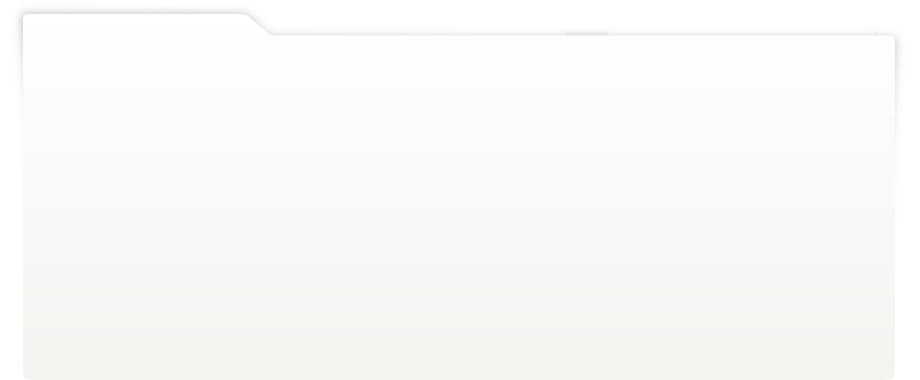
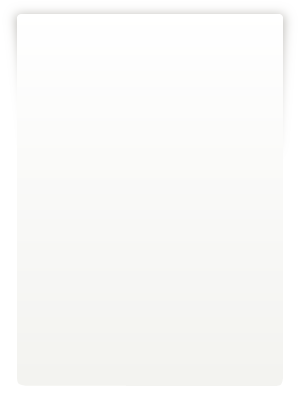
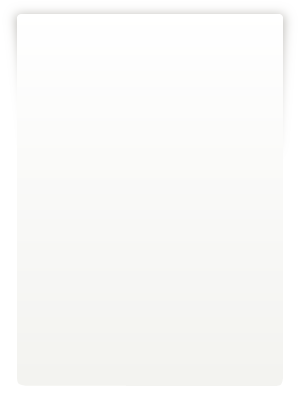
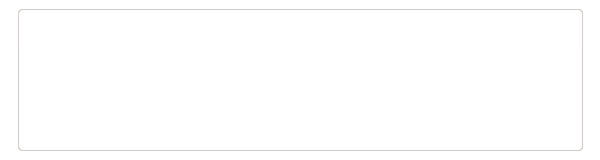
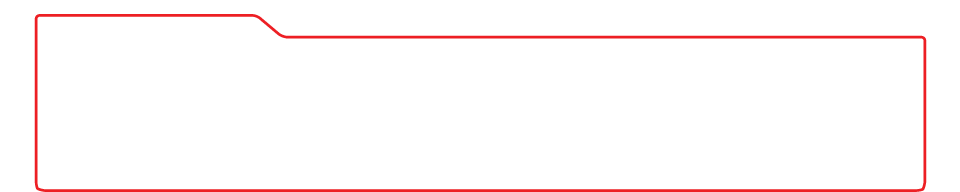
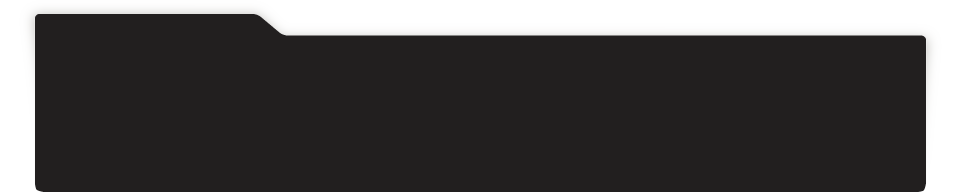
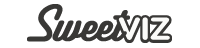
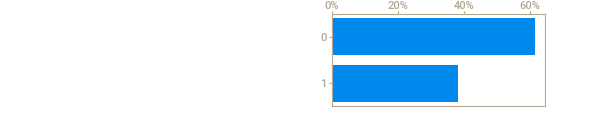
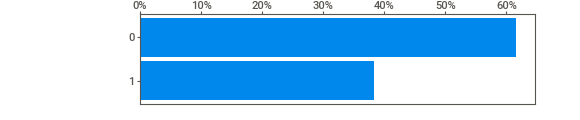
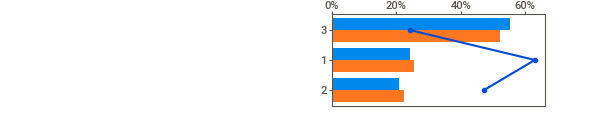
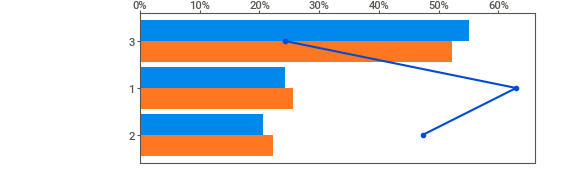
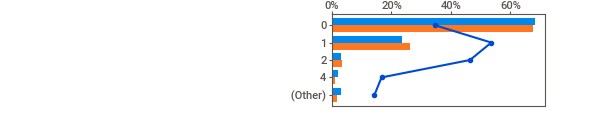
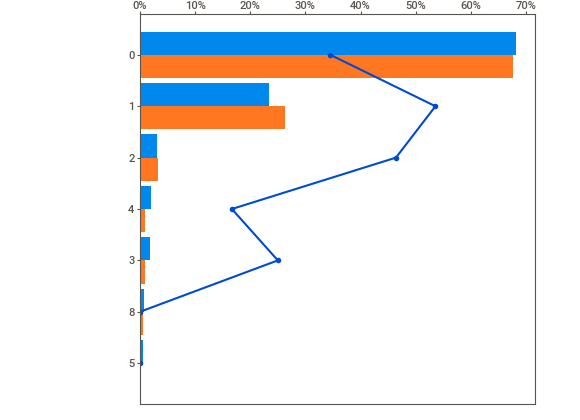
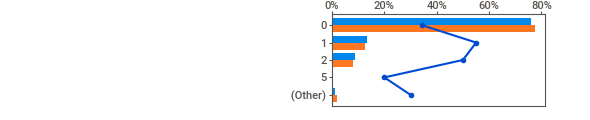
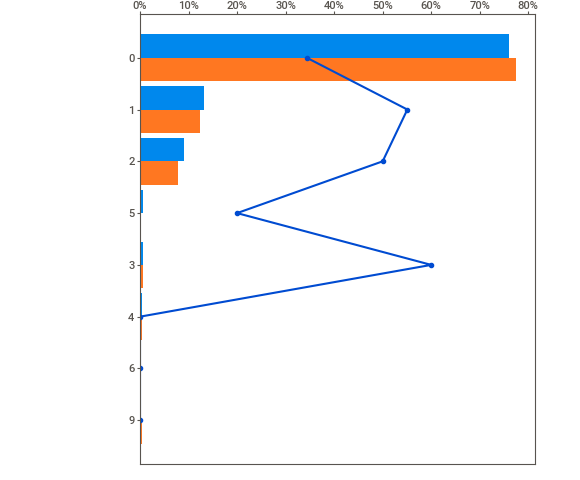
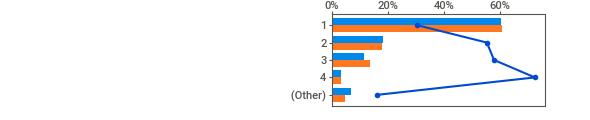
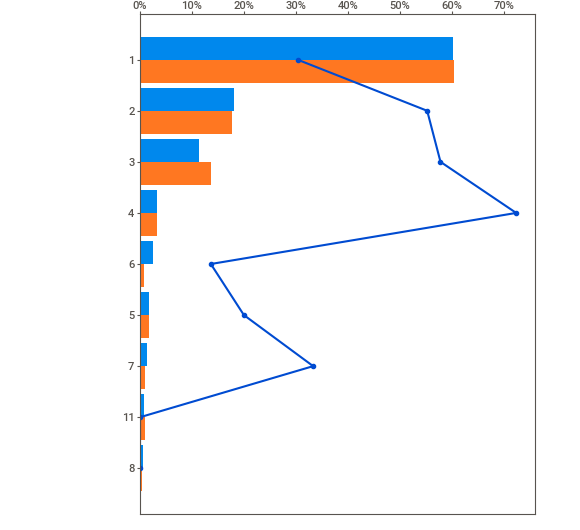
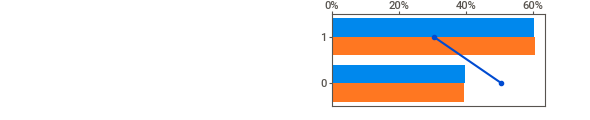
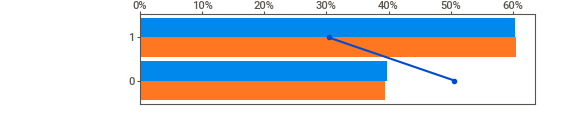
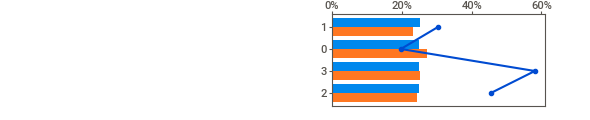
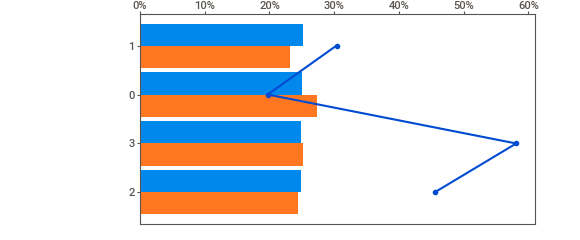
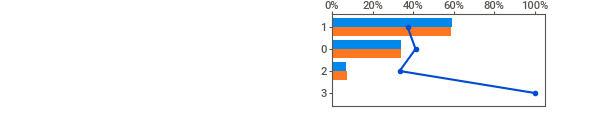
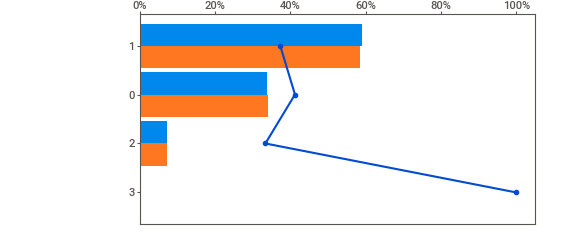
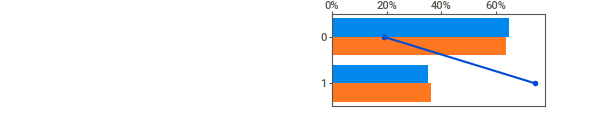
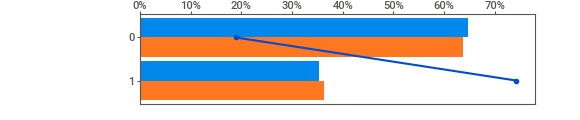
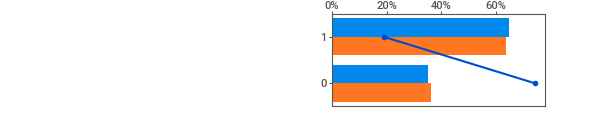
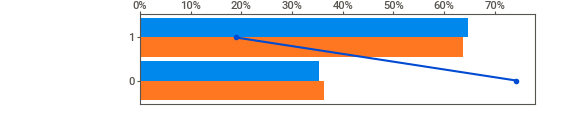
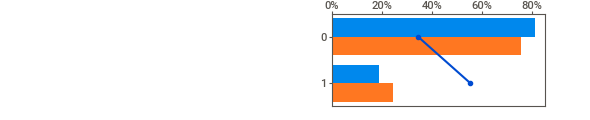
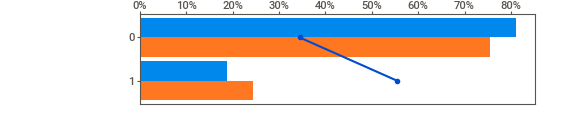
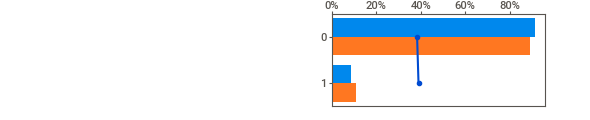
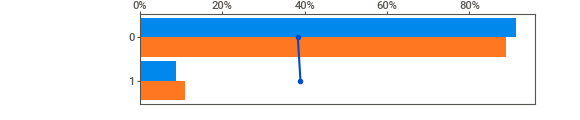
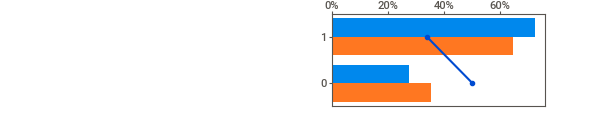
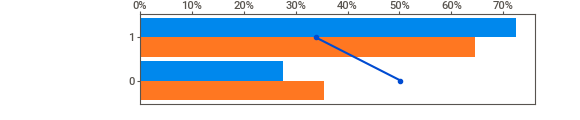
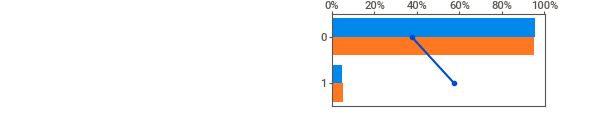
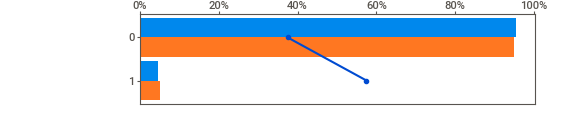
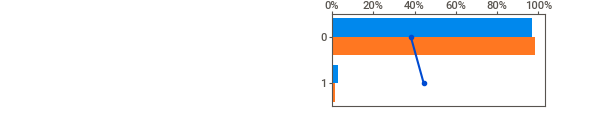
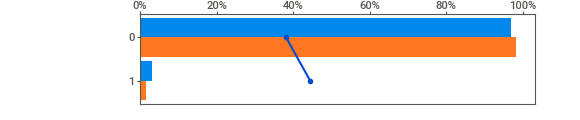
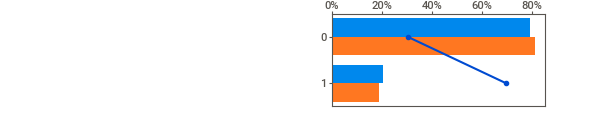
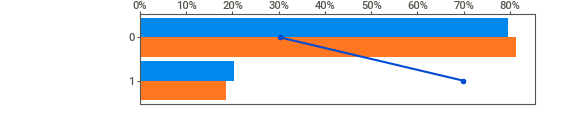
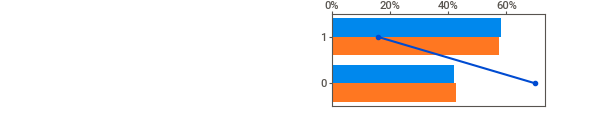
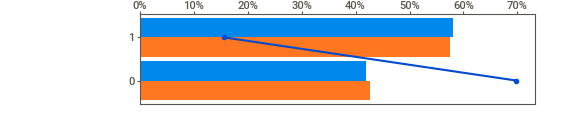
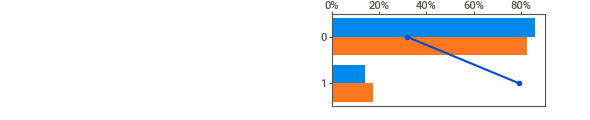
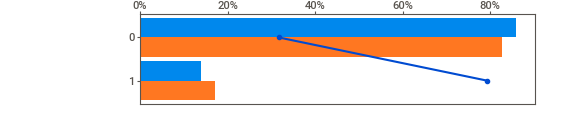
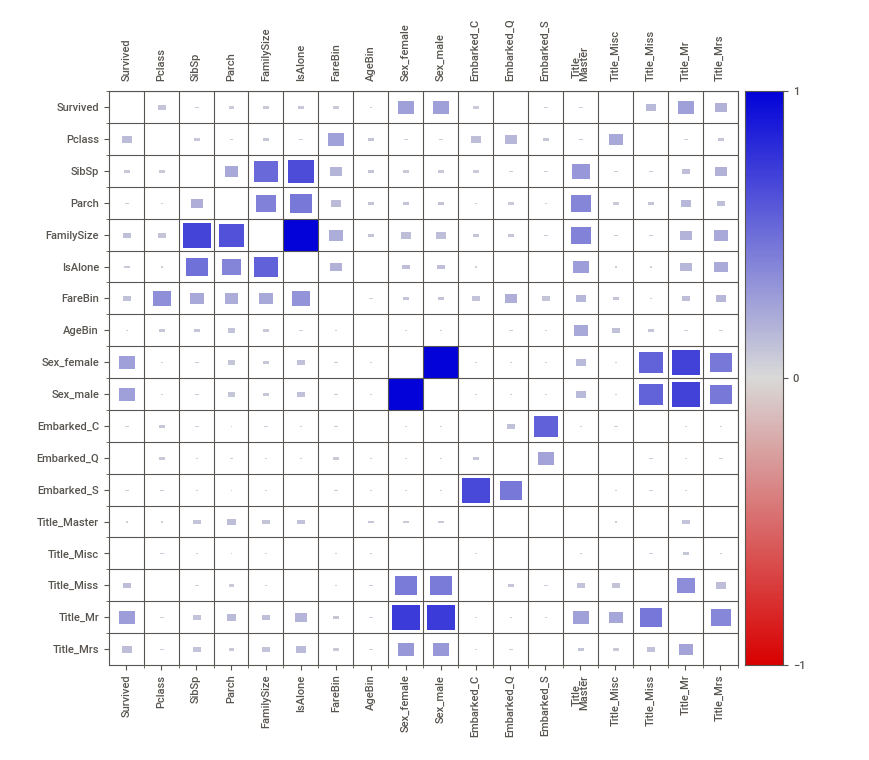
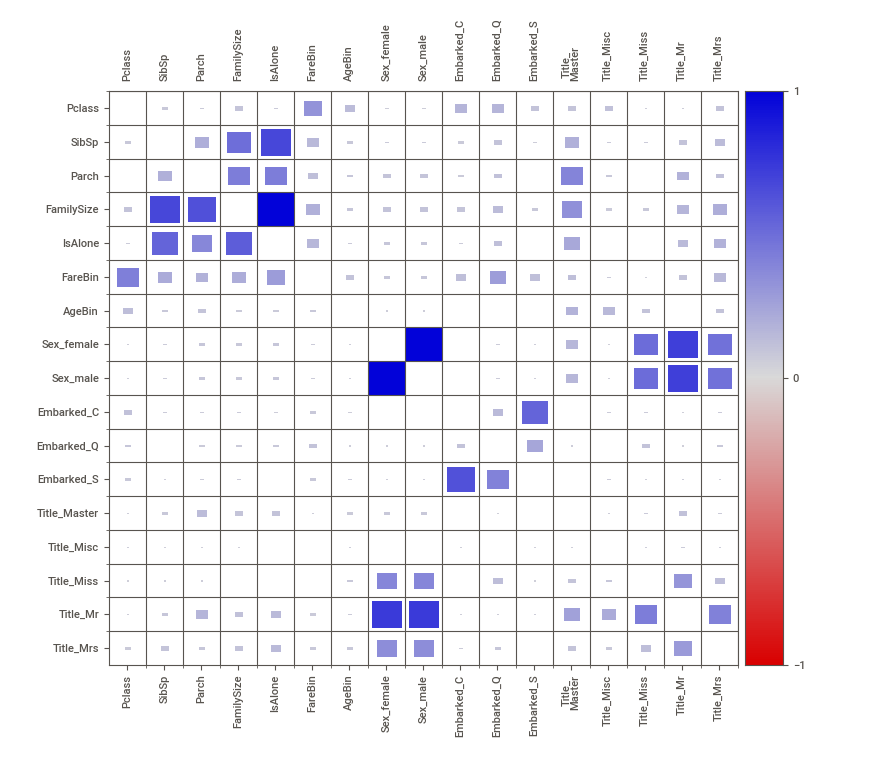

In [28]:
report = sv.compare([train_data, "Train"], [test_data, "Test"], target_feat="Survived")
report.show_notebook()

In [29]:
y = train_data.pop("Survived")
X = train_data

# Modelling

# Lazypredict

In [30]:
!pip install lazypredict
clear_output()

In [31]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

def lazy_predict(X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)
    return models, predictions

lazy_predict(X, y)[0][:10]

100%|██████████| 29/29 [00:01<00:00, 24.24it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.85,0.84,0.84,0.85,0.06
XGBClassifier,0.83,0.83,0.83,0.83,0.25
RandomForestClassifier,0.83,0.82,0.82,0.83,0.15
NuSVC,0.82,0.81,0.81,0.82,0.03
BaggingClassifier,0.82,0.81,0.81,0.82,0.03
CalibratedClassifierCV,0.82,0.81,0.81,0.82,0.12
RidgeClassifierCV,0.82,0.81,0.81,0.82,0.02
RidgeClassifier,0.82,0.81,0.81,0.82,0.02
LinearDiscriminantAnalysis,0.82,0.81,0.81,0.82,0.02


# Single Model

In [32]:
from sklearn.linear_model import RidgeClassifier

## Feature Selection

In [33]:
from sklearn.feature_selection import RFECV

one_clf = RidgeClassifier()
selector = RFECV(one_clf)
selector.fit(X, y)

RFECV(estimator=RidgeClassifier())

In [34]:
new_features = train_data.columns.values[selector.get_support()]
new_features

array(['Pclass', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male',
       'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss',
       'Title_Mr', 'Title_Mrs'], dtype=object)

In [35]:
lazy_predict(X[new_features], y)[0][:10]

100%|██████████| 29/29 [00:00<00:00, 33.67it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearSVC,0.83,0.82,0.82,0.83,0.03
NuSVC,0.82,0.81,0.81,0.82,0.02
CalibratedClassifierCV,0.82,0.81,0.81,0.82,0.09
LinearDiscriminantAnalysis,0.82,0.81,0.81,0.82,0.01
RidgeClassifierCV,0.82,0.81,0.81,0.82,0.01
RidgeClassifier,0.82,0.81,0.81,0.82,0.01
AdaBoostClassifier,0.82,0.80,0.80,0.81,0.08
LogisticRegression,0.82,0.80,0.80,0.81,0.02
LGBMClassifier,0.82,0.80,0.80,0.81,0.06


## Model Selection (tuning)

In [36]:
from sklearn.model_selection import GridSearchCV

tuning_params = {
    "alpha": [0.2, 0.4, 0.6, 0.8, 1],
    "normalize": [False, True],
    "tol": [1e-2, 1e-3, 1e-4, 1e-5],
    "solver": ["svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"],
    }

search = GridSearchCV(one_clf, tuning_params, "accuracy")
search.fit(X[new_features], y)
search.best_params_

{'alpha': 0.2, 'normalize': False, 'solver': 'sag', 'tol': 0.01}

In [37]:
from sklearn.model_selection import ShuffleSplit, cross_validate

one_clf = RidgeClassifier(**search.best_params_).fit(X[new_features], y)

cv_split = ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 42)
result = cross_validate(one_clf, X[new_features], y, cv=cv_split, return_train_score=True)

train_score = result["train_score"].mean()
test_score = result["test_score"].mean()

print("CV Train Score mean:", train_score)
print("CV Test Score mean:", test_score)

CV Train Score mean: 0.8295880149812735
CV Test Score mean: 0.8358208955223881


## Prediction 🎉

In [39]:
predictions = one_clf.predict(test_data[new_features])
output = pd.DataFrame({'PassengerId': test_ids, 'Survived': predictions})
output.to_csv(submission_dir / "single_model_submission.csv", index=False)
output

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


# Ensemble

## Model Selection (tuning)

In [40]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier

estimators=[
        ("xgb", XGBClassifier()),
        ("lr", LogisticRegression()),
        ("rc", RidgeClassifier()),
        ("rccv", RidgeClassifierCV()),
        ("lda", LinearDiscriminantAnalysis()),
        ("cccv", CalibratedClassifierCV()),
        ("svc", SVC()),
        ("lsvc", LinearSVC()),
        ("nc", NearestCentroid()),
        ("ada", AdaBoostClassifier())
    ]

grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [0.1, 0.25, 0.5, 0.75, 1.0]
grid_lr = [0.01, 0.03, 0.05, 0.1, 0.25]
grid_max_depth = [1, 2, 3, 4, 6, 8]
grid_min_samples = [5, 10, 0.03, 0.05, 0.1]
grid_bool = [True, False]
grid_C = [0.01, 0.1, 1, 10, 100]

multiple_params = [
    {
        "learning_rate": grid_lr,
        "max_depth": grid_max_depth,
        "n_estimators": grid_n_estimator,
    },
    {
        "C": grid_C,
        "penalty": ["l1", "l2", "elasticnet"],
        "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    },
    {
        "alpha": grid_ratio,
        "normalize": grid_bool,
        "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"],
    },
    {
        "fit_intercept": grid_bool,
        "normalize": grid_bool,
    },
    {
        "solver": ["svd", "lsqr", "eigen"],
    },
    {
        "method": ["sigmoid", "isotonic"],
    },
    {
        "C": grid_C,
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "degree": grid_max_depth,
        "gamma": ["scale", "auto"],
    },
    {
        "penalty": ["l1", "l2"],
        "loss": ["hinge", "squared_hinge"],
        "C": grid_C,
        "fit_intercept": grid_bool,
    },
    {},
    {
        "n_estimators": grid_n_estimator,
        "learning_rate": grid_lr,
        "algorithm": ["SAMME", "SAMME.R"],
    },
]

for (algo, clf), params in zip(estimators, multiple_params):
    search = GridSearchCV(clf, params)
    search.fit(X[new_features], y)

    print(algo, ":", search.best_params_)
    clf.set_params(**search.best_params_)

xgb : {'learning_rate': 0.03, 'max_depth': 1, 'n_estimators': 300}
lr : {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
rc : {'alpha': 0.5, 'normalize': False, 'solver': 'auto'}
rccv : {'fit_intercept': True, 'normalize': False}
lda : {'solver': 'svd'}
cccv : {'method': 'sigmoid'}
svc : {'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
lsvc : {'C': 0.1, 'fit_intercept': True, 'loss': 'squared_hinge', 'penalty': 'l2'}
nc : {}
ada : {'algorithm': 'SAMME', 'learning_rate': 0.25, 'n_estimators': 300}


## Voting Ensembling

In [41]:
vote_clf = VotingClassifier(
    estimators=estimators,
    voting='hard'
)

vote_clf.fit(X[new_features], y)

cv_split = ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 42)
result = cross_validate(vote_clf, X[new_features], y, cv=cv_split, return_train_score=True)

train_score = result["train_score"].mean()
test_score = result["test_score"].mean()

print("CV Train Score mean:", train_score)
print("CV Test Score mean:", test_score)

CV Train Score mean: 0.8320224719101124
CV Test Score mean: 0.8414179104477613


## Prediction 🎉

In [42]:
predictions = vote_clf.predict(test_data[new_features])
output = pd.DataFrame({'PassengerId': test_ids, 'Survived': predictions})
output.to_csv(submission_dir / 'ensemble_submission.csv', index=False)
output

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
